# MLTOX: Spark ML Pipeline

In [1]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import numpy as np
from pyspark import SparkContext
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import * 
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.sql.types import *
import pyspark.sql.functions as F
from google.cloud import bigquery
from pyod.models.loci import LOCI
import pyflux as pf
from kafka import KafkaConsumer

In [2]:
def cleanText(column):
    return F.trim(F.lower(F.regexp_replace(column, '([^\s\w_]|_)+', ''))).alias('text')

def stem(in_vec):
    out_vec = []
    for t in in_vec:
        t_stem = stemmer.stem(t)
        if len(t_stem) > 2:
            out_vec.append(t_stem)       
    return out_vec

def zipindexdf(df):
    schema_new = df.schema.add("index", LongType(), False)
    return df.rdd.zipWithIndex().map(lambda l: list(l[0]) + [l[1]]).toDF(schema_new)

In [3]:
tweets = pd.read_csv('toxic-data/tweets_training.csv', encoding='latin-1')
tweets = tweets.drop('timestamp', axis=1)
tweets.columns = ['text', 'label']
tweets.head()

,text,label
0,RT @BuckSexton: Just gonna say this once: If y...,24.613045
1,"RT @CNN: It's hiatus time for the crew at ""Jeo...",39.270386
2,RT @rojawi: A primary challenge can weaken an ...,17.155070
3,RT @DineshDSouza: Wonderful! Beto tells us tha...,71.434260
4,RT @cnnbrk: The Environmental Protection Agenc...,16.205998


In [4]:
X = tweets
X = X.sample(frac=1).reset_index()
X = X.drop(X.columns[0], axis=1)
X.head()

,text,label
0,RT @ryangrim: Rep. Andy Barr invited AOC to co...,38.309774
1,SCOOP: Rashida Tlaib Hosts Another Extreme Ant...,60.797810
2,RT @TheRealREDii: @LisaBritton Iâd say #Alex...,22.221705
3,@gavinhanson @kriers It's not a binary choice....,14.742798
4,RT @ChicagoMGD_SD: Bernie is a man who hired w...,52.803797


In [5]:
X.to_csv('toxic-data/tweets_legit.csv', index=False)

In [6]:
spark = SparkSession.builder.appName('toxicity-detector').getOrCreate()
df = spark.read.csv('toxic-data/tweets_legit.csv', header=True, mode="DROPMALFORMED")
df = df.select(cleanText(F.col('text')), F.col('label'))
df = df.withColumn("label", df["label"].cast(DoubleType()))
df = df.na.drop(subset=["text", "label"])

In [7]:
train, test = df.randomSplit([0.75, 0.25], seed=12345)

In [25]:
tok = Tokenizer(inputCol="text", outputCol="words") 
removed = StopWordsRemover(inputCol="words", outputCol="filtered")
htf = HashingTF(inputCol="filtered", outputCol="tf", numFeatures=200)
idf = IDF(inputCol="tf", outputCol="tfidf")
#w2v = Word2Vec(inputCol="words", outputCol="w2v")
#va = VectorAssembler(inputCols=["tfidf", "w2v"], outputCol="features")
va = VectorAssembler(inputCols=["tfidf"], outputCol="features")
gbt = GBTRegressor()

In [26]:
pipeline = Pipeline(stages=[tok, removed, htf, idf, va, gbt])
#pipeline = Pipeline(stages=[tok, removed, htf, idf, w2v, va, gbt])

In [27]:
paramGrid = ParamGridBuilder() \
    .addGrid(htf.numFeatures, [10, 100, 1000]) \
    .addGrid(gbt.maxDepth, [5, 8, 10, 20]) \
    .addGrid(gbt.maxIter, [10, 20, 50, 100]) \
    .build()

In [28]:
evaluator = RegressionEvaluator(metricName="rmse")
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

In [30]:
model = crossval.fit(train)
model

CrossValidatorModel_2dd0d7e9a2fd

In [31]:
model.bestModel.write().overwrite().save('spark-gradientboosting-toxic-tagger-cv')

In [8]:
model = PipelineModel.load('spark-gradientboosting-toxic-tagger-cv')

In [40]:
prediction = model.transform(test).select(F.col("label"), F.col("prediction"))
prediction.show()

+------------------+------------------+
|             label|        prediction|
+------------------+------------------+
|         37.150908|16.707633992961796|
|          53.09683| 51.57663165640131|
|          53.09683| 51.57663165640131|
|          53.09683| 51.57663165640131|
|          53.09683| 51.57663165640131|
|          53.09683| 51.57663165640131|
|40.047276000000004|35.350306879753504|
| 8.772462599999999|23.426745539614277|
|         21.004884| 29.93864520533092|
|           30.7749| 36.20351456519648|
|         20.767283|32.250929085129656|
|         17.013475|25.111167608704577|
|11.212595599999998|  44.5596852951998|
|        10.4985304|34.168561388513865|
|         22.797832| 29.93864520533092|
|         50.564337| 28.29655757280909|
|         21.400388|23.235419335831864|
|28.168446000000007| 45.91409650665748|
|12.080839999999998|33.162195743118964|
|         15.731607| 29.93864520533092|
+------------------+------------------+
only showing top 20 rows



In [41]:
prediction = prediction.toPandas()
prediction.head()

,label,prediction
0,37.150908,16.707634
1,53.096830,51.576632
2,53.096830,51.576632
3,53.096830,51.576632
4,53.096830,51.576632


In [17]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(prediction.label, prediction.prediction))

16.89656649770372

In [18]:
np.mean(prediction.label)

33.36243253870057

In [32]:
prediction = model.transform(test).select(F.col("label"), F.col("prediction"))
prediction.show()

+------------------+------------------+
|             label|        prediction|
+------------------+------------------+
|         37.150908|16.707633992961796|
|          53.09683| 51.57663165640131|
|          53.09683| 51.57663165640131|
|          53.09683| 51.57663165640131|
|          53.09683| 51.57663165640131|
|          53.09683| 51.57663165640131|
|40.047276000000004|35.350306879753504|
| 8.772462599999999|23.426745539614277|
|         21.004884| 29.93864520533092|
|           30.7749| 36.20351456519648|
|         20.767283|32.250929085129656|
|         17.013475|25.111167608704577|
|11.212595599999998|  44.5596852951998|
|        10.4985304|34.168561388513865|
|         22.797832| 29.93864520533092|
|         50.564337| 28.29655757280909|
|         21.400388|23.235419335831864|
|28.168446000000007| 45.91409650665748|
|12.080839999999998|33.162195743118964|
|         15.731607| 29.93864520533092|
+------------------+------------------+
only showing top 20 rows



In [28]:
prediction = prediction[(prediction['prediction'] > 20) & (prediction['prediction'] < 50)]

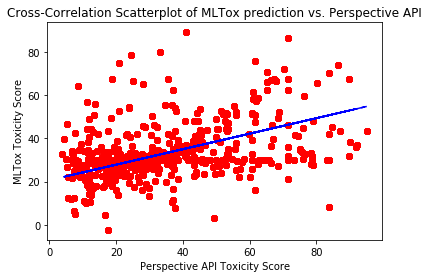

In [49]:
import matplotlib.pyplot as plt
plt.plot(prediction.label,prediction.prediction,'ro')
plt.title('Cross-Correlation Scatterplot of MLTox prediction vs. Perspective API')
plt.xlabel("Perspective API Toxicity Score")
plt.ylabel("MLTox Toxicity Score")
x = prediction['label']
y = prediction['prediction']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")
plt.show()

In [50]:
import scipy
scipy.stats.pearsonr(prediction.prediction,prediction.label)

(0.5314052809094576, 7.563297317382702e-53)